In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('../../Datasets/ab-test/AdSmartABdata.csv')

In [3]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [5]:
if (df['auction_id'].nunique() == len(df)):
    print("No Duplicate")
else:
    print("some Duplicate rows found!")
    
    
if (df.isnull().sum().sum() == 0):
    print("No Null value")
else:
    print("some Null values found!")
    

No Duplicate
No Null value


In [6]:
df['response'] = df[['yes','no']].apply(lambda x: 1 if((x['yes'] == 1) | (x['no'] == 1)) else 0, axis=1)
df.query('no == 0 and yes == 0')

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,response
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0,0
...,...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0,0


In [7]:
print('overall reponse stats:')
df_response_pivot = df.pivot_table(index=['experiment'], values=['yes', 'no', 'response'],
               aggfunc=lambda x:f'{x.sum()/ len(df) * 100 :.2f} %',
               sort=False,
               margins=True,
               margins_name='Total'
              )

df_response_pivot

overall reponse stats:


,yes,no,response
experiment,,,
exposed,3.81 %,4.32 %,8.13 %
control,3.27 %,3.99 %,7.26 %
Total,7.08 %,8.31 %,15.39 %


In [8]:
df['response'].value_counts()

0    6834
1    1243
Name: response, dtype: int64

<Axes: xlabel='response', ylabel='count'>

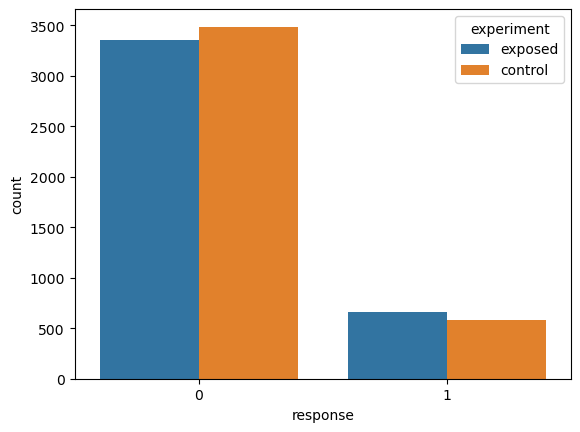

In [9]:
sns.countplot(x='response', data=df, hue='experiment')

In [10]:
# df.query('yes == 1 | no == 1')
interacted = df[(df['yes'] == 1) | (df['no'] == 1)]

In [11]:
exposed = interacted[interacted['experiment'] == 'exposed']
control = interacted[interacted['experiment'] == 'control']

In [12]:
(exposed.pivot_table(index=['experiment'], values=['yes', 'no', 'response'],
               aggfunc=lambda x:f'{x.sum()/ len(exposed) * 100 :.2f} %',
               sort=False,
              ))

,yes,no,response
experiment,,,
exposed,46.88 %,53.12 %,100.00 %


In [13]:
control.pivot_table(index=['experiment'], values=['yes', 'no','response'],
               aggfunc=lambda x:f'{x.sum()/ len(control) * 100 :.2f} %',
               sort=False,
              )

,yes,no,response
experiment,,,
control,45.05 %,54.95 %,100.00 %


In [14]:
exposed_yes_mean = exposed['yes'].mean()
control_yes_mean = control['yes'].mean()

print(f'exposed yes mean: {exposed_yes_mean :.2f}')
print(f'control yes mean: {control_yes_mean :.2f}')


exposed yes mean: 0.47
control yes mean: 0.45


In [15]:
print(f'exposed group observasions: {len(exposed)}')
print(f"convertion rate in exposed group: { exposed_yes_mean * 100 :.2f}%\n")

print(f'control group observasions: {len(control)}')
print(f"convertion rate in control group: { control_yes_mean * 100 :.2f}%")

exposed group observasions: 657
convertion rate in exposed group: 46.88%

control group observasions: 586
convertion rate in control group: 45.05%


In [16]:
mean_diff = exposed_yes_mean - control_yes_mean
print(f'mean diff   (value): {mean_diff :.4f}')
print(f'mean diff (percent): {mean_diff * 100 :.2f}%')


mean diff   (value): 0.0183
mean diff (percent): 1.83%


In [17]:
expose_convert = exposed[exposed['yes'] == 1].shape[0]
control_convert = control[control['yes'] == 1].shape[0]

print('exposed conversion: ', expose_convert)
print('control conversion: ', control_convert)


exposed conversion:  308
control conversion:  264


In [18]:
converted = np.array([expose_convert, control_convert])
population_size = np.array([len(exposed), len(control)])

In [19]:
stat, p_val = proportions_ztest(count=converted, nobs=population_size, alternative='larger')
print(f'P-Value: {p_val * 100:.2f}%')

P-Value: 25.92%


In [20]:
n = 100000
exposed_sim = np.random.binomial(n=len(exposed), p=exposed_yes_mean, size=n)
control_sim = np.random.binomial(n=len(control), p=control_yes_mean, size=n)

In [21]:
sim_diff = exposed_sim - control_sim
sim_diff.sort()
sim_diff

array([-40, -33, -29, ..., 114, 127, 131])

In [22]:
# len(diff_sim[diff_sim > mean_diff]) / n * 100
len(sim_diff[sim_diff < p_val]) / n * 100


0.6779999999999999

In [23]:
mean_diff

0.018285619295484168

In [24]:
(sim_diff < mean_diff).mean() * 100

0.6779999999999999

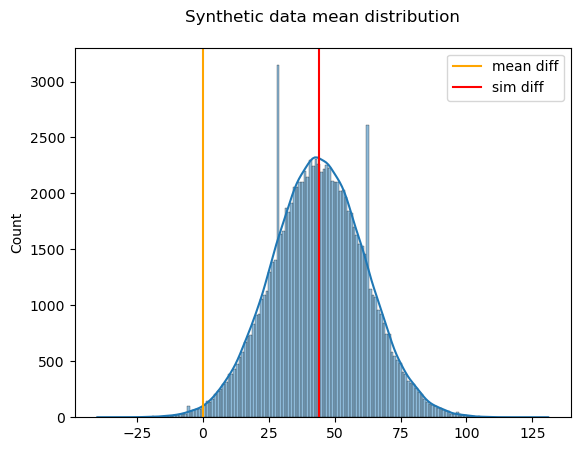

In [25]:
sns.histplot(sim_diff,alpha=0.5, kde=True)

low = mean_diff
high = sim_diff.mean()

plt.axvline(x=low, color='orange',label='mean diff')
plt.axvline(x=high, color='red',label='sim diff')
plt.title("Synthetic data mean distribution\n")
plt.legend()




In [26]:
print(f'sim diff skewness: {stats.skew(sim_diff)}')
print(f'sim diff kurtosis: {stats.kurtosis(sim_diff)}')

sim diff skewness: -0.004898823619293186
sim diff kurtosis: 0.009979026632966015
